# Appendix 10.2.5: Tool use with multiple tools

Now we're going to take our tool use to another level! We're going to provide Claude with a suite of tools it can select from.  Our goal is to build a simple customer support chatbot for a fictional electronics company called TechNova. It will have access to simple tools including: 

* `get_user` to look up user details by email, username, or phone number
* `get_order_by_id` to look up an order directly by its order ID
* `get_customer_orders` to look up all the orders belonging to a customer
* `cancel_order` cancels an order given a specific order ID

This chatbot will be quite limited, but it demonstrates some key pieces of working with multiple tools. 

Here's an image showcasing an example interaction with the chatbot.

![conversation1.png](./images/conversation1.png)

Here's another interaction with the chatbot where we've explicitly printed out a message any time Claude uses a tool, to make it easier to understand what's happening behind the scenes: 

![conversation2.png](./images/conversation2.png)


Here's a diagram showing the flow of information for a potential single chat message:

![chat_diagram.png](./images/chat_diagram.png)

**important note: this chatbot is extremely simple and allows anyone to cancel an order as long as they have the username or email of the user who placed the order. This implementation is for educational purposes and should not be integrated into a real codebase without alteration!**

***

## Our fake database
Before we start working with Claude, we'll begin by defining a very simple `FakeDatabase` class that will hold some fake customers and orders, as well as providing methods for us to interact with the data. In the real world, the chatbot would presumably be connected to one or more *actual* databases.

In [ ]:
class FakeDatabase:
    def __init__(self):
        self.customers = [
            {"id": "1213210", "name": "John Doe", "email": "john@gmail.com", "phone": "123-456-7890", "username": "johndoe"},
            {"id": "2837622", "name": "Priya Patel", "email": "priya@candy.com", "phone": "987-654-3210", "username": "priya123"},
            {"id": "3924156", "name": "Liam Nguyen", "email": "lnguyen@yahoo.com", "phone": "555-123-4567", "username": "liamn"},
            {"id": "4782901", "name": "Aaliyah Davis", "email": "aaliyahd@hotmail.com", "phone": "111-222-3333", "username": "adavis"},
            {"id": "5190753", "name": "Hiroshi Nakamura", "email": "hiroshi@gmail.com", "phone": "444-555-6666", "username": "hiroshin"},
            {"id": "6824095", "name": "Fatima Ahmed", "email": "fatimaa@outlook.com", "phone": "777-888-9999", "username": "fatimaahmed"},
            {"id": "7135680", "name": "Alejandro Rodriguez", "email": "arodriguez@protonmail.com", "phone": "222-333-4444", "username": "alexr"},
            {"id": "8259147", "name": "Megan Anderson", "email": "megana@gmail.com", "phone": "666-777-8888", "username": "manderson"},
            {"id": "9603481", "name": "Kwame Osei", "email": "kwameo@yahoo.com", "phone": "999-000-1111", "username": "kwameo"},
            {"id": "1057426", "name": "Mei Lin", "email": "meilin@gmail.com", "phone": "333-444-5555", "username": "mlin"}
        ]

        self.orders = [
            {"id": "24601", "customer_id": "1213210", "product": "Wireless Headphones", "quantity": 1, "price": 79.99, "status": "Shipped"},
            {"id": "13579", "customer_id": "1213210", "product": "Smartphone Case", "quantity": 2, "price": 19.99, "status": "Processing"},
            {"id": "97531", "customer_id": "2837622", "product": "Bluetooth Speaker", "quantity": 1, "price": "49.99", "status": "Shipped"}, 
            {"id": "86420", "customer_id": "3924156", "product": "Fitness Tracker", "quantity": 1, "price": 129.99, "status": "Delivered"},
            {"id": "54321", "customer_id": "4782901", "product": "Laptop Sleeve", "quantity": 3, "price": 24.99, "status": "Shipped"},
            {"id": "19283", "customer_id": "5190753", "product": "Wireless Mouse", "quantity": 1, "price": 34.99, "status": "Processing"},
            {"id": "74651", "customer_id": "6824095", "product": "Gaming Keyboard", "quantity": 1, "price": 89.99, "status": "Delivered"},
            {"id": "30298", "customer_id": "7135680", "product": "Portable Charger", "quantity": 2, "price": 29.99, "status": "Shipped"},
            {"id": "47652", "customer_id": "8259147", "product": "Smartwatch", "quantity": 1, "price": 199.99, "status": "Processing"},
            {"id": "61984", "customer_id": "9603481", "product": "Noise-Cancelling Headphones", "quantity": 1, "price": 149.99, "status": "Shipped"},
            {"id": "58243", "customer_id": "1057426", "product": "Wireless Earbuds", "quantity": 2, "price": 99.99, "status": "Delivered"},
            {"id": "90357", "customer_id": "1213210", "product": "Smartphone Case", "quantity": 1, "price": 19.99, "status": "Shipped"},
            {"id": "28164", "customer_id": "2837622", "product": "Wireless Headphones", "quantity": 2, "price": 79.99, "status": "Processing"}
        ]

    def get_user(self, key, value):
        if key in {"email", "phone", "username"}:
            for customer in self.customers:
                if customer[key] == value:
                    return customer
            return f"Couldn't find a user with {key} of {value}"
        else:
            raise ValueError(f"Invalid key: {key}")

        return None

    def get_order_by_id(self, order_id):
        for order in self.orders:
            if order["id"] == order_id:
                return order
        return None

    def get_customer_orders(self, customer_id):
        return [order for order in self.orders if order["customer_id"] == customer_id]

    def cancel_order(self, order_id):
        order = self.get_order_by_id(order_id)
        if order:
            if order["status"] == "Processing":
                order["status"] = "Cancelled"
                return "Cancelled the order"
            else:
                return "Order has already shipped.  Can't cancel it."
        return "Can't find that order!"

We'll create an instance of the `FakeDatabase`:

In [ ]:
db = FakeDatabase()

Let's make sure our `get_user` method works as intended.  It's expecting us to pass in a `key` that is one of: 

* "email"
* "username"
* "phone" 

It also expects a corresponding `value` that it will use to perform a basic search, hopefully returning the matching user.

In [ ]:
db.get_user("email", "john@gmail.com")

In [ ]:
db.get_user("username", "adavis")

In [ ]:
db.get_user("phone", "666-777-8888")

We can also get a list of all orders that belong to a particular customer by calling `get_customer_orders` and passing in a customer ID:

In [ ]:
db.get_customer_orders("1213210")

In [ ]:
db.get_customer_orders("9603481")

We also can look up a single order directly if we have the order ID:

In [ ]:
db.get_order_by_id('24601')

Lastly, we can use the `cancel_order` method to cancel an order. Orders can only be cancelled if they are "processing". We can't cancel an order that has already shipped!  The method expects us to pass in an order_id of the order we want to cancel.

In [ ]:
#Let's look up an order that has a status of processing:
db.get_order_by_id("47652")

In [ ]:
#Now let's cancel it! 
db.cancel_order("47652")

In [ ]:
# It's status should now be "Cancelled"
db.get_order_by_id("47652")

***

## Writing our tools

Now that we've tested our (very) simple fake database functionality, let's write JSON schemas that define the structure of the tools. Let's take a look at a very simple tool that corresponds to our `get_order_by_id` method:

In [ ]:
tool1 = {
      "toolSpec": {
        "name": "get_order_by_id",
        "description": "Retrieves the details of a specific order based on the order ID. Returns the order ID, product name, quantity, price, and order status.",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "order_id": {
                "type": "string",
                "description": "The unique identifier for the order."}
            },
            "required": ["order_id"]
          }
        }
      }
    }

As always, we include a name, a description, and an overview of the inputs.  In this case, there is a single input, `order_id`, and it is required. 

Now let's take a look at a more complex tool that corresponds to the `get_user` method.  Recall that this method has two arguments:

1. A `key` argument that is one of the following strings:
    * "email"
    * "username"
    * "phone" 
2. A `value` argument which is the term we'll be using to search (the actual email, phone number, or username)

Here's the corresponding tool definition:

In [ ]:
tool2 = {
      "toolSpec": {
        "name": "get_user",
        "description": "Looks up a user by email, phone, or username.",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "key": {
                "type": "string",
                "enum": ["email", "phone", "username"],
                "description": "The attribute to search for a user by (email, phone, or username)."},
              "value": {
                "type": "string",
                "description": "The value to match for the specified attribute."}
            },
            "required": ["key", "value"]
          }
        }
      }
    }

Pay special attention to the way we define the set of possible valid options for `key` using `enum` in the schema.

We still have two more tools to write, but to save time, we'll just provide you the complete list of tools ready for us to use. (You're welcome to try defining them youself first as an exercise!)

In [ ]:
toolConfig = {
  'tools': [
    {
      'toolSpec': {
        'name': 'get_user',
        'description': 'Looks up a user by email, phone, or username.',
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'key': {
                'type': 'string',
                'enum': ['email', 'phone', 'username'],
                'description': 'The attribute to search for a user by (email, phone, or username).'
              },
              'value': {
                'type': 'string',
                'description': 'The value to match for the specified attribute.'
              }
            },
            'required': ['key', 'value']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'get_order_by_id',
        'description': 'Retrieves the details of a specific order based on the order ID. Returns the order ID, product name, quantity, price, and order status.',
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'order_id': {
                'type': 'string',
                'description': 'The unique identifier for the order.'
              }
            },
            'required': ['order_id']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'get_customer_orders',
        'description': "Retrieves the list of orders belonging to a user based on a user's customer id.",
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'customer_id': {
                'type': 'string',
                'description': 'The customer_id belonging to the user'
              }
            },
            'required': ['customer_id']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'cancel_order',
        'description': "Cancels an order based on a provided order_id.  Only orders that are 'processing' can be cancelled",
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'order_id': {
                'type': 'string',
                'description': 'The order_id pertaining to a particular order'
              }
            },
            'required': ['order_id']
          }
        }
      }
    }
  ],
  'toolChoice': {
    'auto': {}
  }
}

***

## Giving our tools to Claude

Next up, we need to do a few things: 
1. Tell Claude about our tools and send the user's chat message to Claude.
2. Handle the response we get back from Claude:
    * If Claude doesn't want to use a tool:
        * Print Claude's output to the user.
        * Ask the user for their next message.
    * If Claude does want to use a tool
        * Verify that Claude called one of the appropriate tools.
        * Execute the underlying function, like `get_user` or `cancel_order`.
        * Send Claude the result of running the tool.

Eventually, the goal is to write a command line script that will create an interactive chatbot that will run in a loop. But to keep things simple, we'll start by writing the basic code linearly.  We'll end by creating an interactive chatbot script.

We start with a function that can translate Claude's tool use response into an actual method call on our `db`: 

In [ ]:
def process_tool_call(tool_name, tool_input):
    if tool_name == "get_user":
        return db.get_user(tool_input["key"], tool_input["value"])
    elif tool_name == "get_order_by_id":
        return db.get_order_by_id(tool_input["order_id"])
    elif tool_name == "get_customer_orders":
        return db.get_customer_orders(tool_input["customer_id"])
    elif tool_name == "cancel_order":
        return db.cancel_order(tool_input["order_id"])

Let's start with a simple demo that shows Claude can decide which tool to use when presented with a list of multiple tools. We'll ask Claude `Can you look up my orders? My email is john@gmail.com` and see what happens!

In [ ]:
import boto3
import json
from datetime import datetime
from botocore.exceptions import ClientError

session = boto3.Session()
region = session.region_name

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'

print(f'Using modelId: {modelId}')
print('Using region: ', region)

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)

In [ ]:
messages = [{"role": "user", "content": [{"text": "Can you look up my orders? My email is john@gmail.com"}]}]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"maxTokens": 4096},
    "toolConfig":toolConfig,
}

response = bedrock_client.converse(**converse_api_params)

In [ ]:
print(response['output']['message']['content'][-1])

Claude wants to use the `get_user` tool.

Now we'll write the basic logic to update our messages list, call the appropriate tool, and update our messages list again with the tool results.

In [ ]:
# Update messages to include Claude's response
messages.append(
    {"role": "assistant", "content": response['output']['message']['content']}
)

tool_use = response['output']['message']['content'][-1]
tool_id = tool_use['toolUse']['toolUseId']
tool_name = tool_use['toolUse']['name']
tool_input = tool_use['toolUse']['input']

#If Claude stops because it wants to use a tool:
if response['stopReason'] == "tool_use":
    tool_use = response['output']['message']['content'][-1] #Naive approach assumes only 1 tool is called at a time
    tool_id = tool_use['toolUse']['toolUseId']
    tool_name = tool_use['toolUse']['name']
    tool_input = tool_use['toolUse']['input']

    print(f"Claude wants to use the {tool_name} tool")
    print(f"Tool Input:")
    print(json.dumps(tool_input, indent=2))

    #Actually run the underlying tool functionality on our db
    tool_result = process_tool_call(tool_name, tool_input)

    print(f"\nTool Result:")
    print(json.dumps(tool_result, indent=2))

    #Add our tool_result message:
    messages.append({
        "role": "user",
        "content": [
            {
                "toolResult": {
                    "toolUseId": tool_id,
                    "content": [
                        {"text": str(tool_result)}
                    ]
                }
            }
        ]
    })

else: 
    #If Claude does NOT want to use a tool, just print out the text reponse
    print("\nTechNova Support:" + f"response['output']['message']['content'][0]['text']")

This is what our messages list looks like now:

In [ ]:
messages

Now we'll send a second request to Claude using the updated messages list:

In [ ]:
converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"maxTokens": 4096},
    "toolConfig":toolConfig,
}

response2 = bedrock_client.converse(**converse_api_params)

In [ ]:
response2['output']['message']['content'][-1]

Now that Claude has the result of the `get_user` tool, including the user's ID, it wants to call `get_customer_orders` to look up the orders that correspond to this particular customer.  It's picking the right tool for the job. **Note:** there are many potential issues and places Claude could go wrong here, but this is a start!

***

## Writing an interactive script

It's a lot easier to interact with this chatbot via an interactive command line script. 

Here's all of the code from above combined into a single function that starts a loop-based chat session (you'll probably want to run this as its own script from the command line):

In [ ]:
import boto3
import json
from datetime import datetime
from botocore.exceptions import ClientError

session = boto3.Session()
region = session.region_name

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)

class FakeDatabase:
    def __init__(self):
        self.customers = [
            {"id": "1213210", "name": "John Doe", "email": "john@gmail.com", "phone": "123-456-7890", "username": "johndoe"},
            {"id": "2837622", "name": "Priya Patel", "email": "priya@candy.com", "phone": "987-654-3210", "username": "priya123"},
            {"id": "3924156", "name": "Liam Nguyen", "email": "lnguyen@yahoo.com", "phone": "555-123-4567", "username": "liamn"},
            {"id": "4782901", "name": "Aaliyah Davis", "email": "aaliyahd@hotmail.com", "phone": "111-222-3333", "username": "adavis"},
            {"id": "5190753", "name": "Hiroshi Nakamura", "email": "hiroshi@gmail.com", "phone": "444-555-6666", "username": "hiroshin"},
            {"id": "6824095", "name": "Fatima Ahmed", "email": "fatimaa@outlook.com", "phone": "777-888-9999", "username": "fatimaahmed"},
            {"id": "7135680", "name": "Alejandro Rodriguez", "email": "arodriguez@protonmail.com", "phone": "222-333-4444", "username": "alexr"},
            {"id": "8259147", "name": "Megan Anderson", "email": "megana@gmail.com", "phone": "666-777-8888", "username": "manderson"},
            {"id": "9603481", "name": "Kwame Osei", "email": "kwameo@yahoo.com", "phone": "999-000-1111", "username": "kwameo"},
            {"id": "1057426", "name": "Mei Lin", "email": "meilin@gmail.com", "phone": "333-444-5555", "username": "mlin"}
        ]

        self.orders = [
            {"id": "24601", "customer_id": "1213210", "product": "Wireless Headphones", "quantity": 1, "price": 79.99, "status": "Shipped"},
            {"id": "13579", "customer_id": "1213210", "product": "Smartphone Case", "quantity": 2, "price": 19.99, "status": "Processing"},
            {"id": "97531", "customer_id": "2837622", "product": "Bluetooth Speaker", "quantity": 1, "price": "49.99", "status": "Shipped"}, 
            {"id": "86420", "customer_id": "3924156", "product": "Fitness Tracker", "quantity": 1, "price": 129.99, "status": "Delivered"},
            {"id": "54321", "customer_id": "4782901", "product": "Laptop Sleeve", "quantity": 3, "price": 24.99, "status": "Shipped"},
            {"id": "19283", "customer_id": "5190753", "product": "Wireless Mouse", "quantity": 1, "price": 34.99, "status": "Processing"},
            {"id": "74651", "customer_id": "6824095", "product": "Gaming Keyboard", "quantity": 1, "price": 89.99, "status": "Delivered"},
            {"id": "30298", "customer_id": "7135680", "product": "Portable Charger", "quantity": 2, "price": 29.99, "status": "Shipped"},
            {"id": "47652", "customer_id": "8259147", "product": "Smartwatch", "quantity": 1, "price": 199.99, "status": "Processing"},
            {"id": "61984", "customer_id": "9603481", "product": "Noise-Cancelling Headphones", "quantity": 1, "price": 149.99, "status": "Shipped"},
            {"id": "58243", "customer_id": "1057426", "product": "Wireless Earbuds", "quantity": 2, "price": 99.99, "status": "Delivered"},
            {"id": "90357", "customer_id": "1213210", "product": "Smartphone Case", "quantity": 1, "price": 19.99, "status": "Shipped"},
            {"id": "28164", "customer_id": "2837622", "product": "Wireless Headphones", "quantity": 2, "price": 79.99, "status": "Processing"}
        ]

    def get_user(self, key, value):
        if key in {"email", "phone", "username"}:
            for customer in self.customers:
                if customer[key] == value:
                    return customer
            return f"Couldn't find a user with {key} of {value}"
        else:
            raise ValueError(f"Invalid key: {key}")
        
        return None

    def get_order_by_id(self, order_id):
        for order in self.orders:
            if order["id"] == order_id:
                return order
        return None
    
    def get_customer_orders(self, customer_id):
        return [order for order in self.orders if order["customer_id"] == customer_id]

    def cancel_order(self, order_id):
        order = self.get_order_by_id(order_id)
        if order:
            if order["status"] == "Processing":
                order["status"] = "Cancelled"
                return "Cancelled the order"
            else:
                return "Order has already shipped.  Can't cancel it."
        return "Can't find that order!"

toolConfig = {
  'tools': [
    {
      'toolSpec': {
        'name': 'get_user',
        'description': 'Looks up a user by email, phone, or username.',
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'key': {
                'type': 'string',
                'enum': ['email', 'phone', 'username'],
                'description': 'The attribute to search for a user by (email, phone, or username).'
              },
              'value': {
                'type': 'string',
                'description': 'The value to match for the specified attribute.'
              }
            },
            'required': ['key', 'value']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'get_order_by_id',
        'description': 'Retrieves the details of a specific order based on the order ID. Returns the order ID, product name, quantity, price, and order status.',
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'order_id': {
                'type': 'string',
                'description': 'The unique identifier for the order.'
              }
            },
            'required': ['order_id']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'get_customer_orders',
        'description': "Retrieves the list of orders belonging to a user based on a user's customer id.",
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'customer_id': {
                'type': 'string',
                'description': 'The customer_id belonging to the user'
              }
            },
            'required': ['customer_id']
          }
        }
      }
    },
    {
      'toolSpec': {
        'name': 'cancel_order',
        'description': "Cancels an order based on a provided order_id.  Only orders that are 'processing' can be cancelled",
        'inputSchema': {
          'json': {
            'type': 'object',
            'properties': {
              'order_id': {
                'type': 'string',
                'description': 'The order_id pertaining to a particular order'
              }
            },
            'required': ['order_id']
          }
        }
      }
    }
  ],
  'toolChoice': {
    'auto': {}
  }
}

db = FakeDatabase()

def process_tool_call(tool_name, tool_input):
    if tool_name == "get_user":
        return db.get_user(tool_input["key"], tool_input["value"])
    elif tool_name == "get_order_by_id":
        return db.get_order_by_id(tool_input["order_id"])
    elif tool_name == "get_customer_orders":
        return db.get_customer_orders(tool_input["customer_id"])
    elif tool_name == "cancel_order":
        return db.cancel_order(tool_input["order_id"])

def simple_chat():
    user_message = input("\nUser: ")
    messages = [{"role": "user", "content": [{"text": user_message}]}]
    #messages = [{"role": "user", "content": user_message}]
    while True:
        #If the last message is from the assistant, get another input from the user
        if messages[-1].get("role") == "assistant":
            user_message = input("\nUser: ")
            messages.append({"role": "user", "content": [{"text": user_message}]})

        converse_api_params = {
            "modelId": modelId,
            "messages": messages,
            "inferenceConfig": {"maxTokens": 4096},
            "toolConfig":toolConfig,
        }

        response = bedrock_client.converse(**converse_api_params)

        messages.append({"role": "assistant", "content": response['output']['message']['content']})

        #If Claude stops because it wants to use a tool:
        if response['stopReason'] == "tool_use":
            tool_use = response['output']['message']['content'][-1] #Naive approach assumes only 1 tool is called at a time
            tool_id = tool_use['toolUse']['toolUseId']
            tool_name = tool_use['toolUse']['name']
            tool_input = tool_use['toolUse']['input']

            print(f"Claude wants to use the {tool_name} tool")
            print(f"Tool Input:")
            print(json.dumps(tool_input, indent=2))

            #Actually run the underlying tool functionality on our db
            tool_result = process_tool_call(tool_name, tool_input)

            print(f"\nTool Result:")
            print(json.dumps(tool_result, indent=2))

            #Add our tool_result message:
            messages.append({
                "role": "user",
                "content": [
                    {
                        "toolResult": {
                            "toolUseId": tool_id,
                            "content": [
                                {"text": str(tool_result)}
                            ]
                        }
                    }
                ]
            })

        else: 
            #If Claude does NOT want to use a tool, just print out the text reponse
            print("\nTechNova Support:" + f"{response['output']['message']['content'][0]['text']}")

# Start the chat!!
# simple_chat()

Here's an example conversation:

![conversation3.png](./images/conversation3.png)

As you can see, the chatbot is calling the correct tools when needed, but the actual chat responses are not ideal.  We probably don't want a customer-facing chatbot telling users about the specific tools it's going to call!

***

## Prompt enhancements

We can improve the chat experience by providing our chatbot with a solid system prompt.  One of the first things we should do is give Claude some context and tell it that it's acting as a customer service assistant for TechNova.

Here's a start for our system prompt:

In [ ]:
system_prompt = """
You are a customer support chat bot for an online retailer called TechNova. 
Your job is to help users look up their account, orders, and cancel orders.
Be helpful and brief in your responses.
"""

Don't forget to pass this prompt into the `system` parameter when making requests to Claude!

Here's a sample conversation after adding in the above system prompt details:

![conversation4.png](./images/conversation4.png)

Notice that the assistant knows it is a support bot for TechNova, and it no longer tells the user about its tools.  It might also be worth explicitly telling Claude not to reference tools at all.

**Note:** The `=======Claude wants to use the cancel_order_tool=======` lines are logging we added to the script, not Claude's actual outputs!

If you play with this script enough, you'll likely notice other issues.  One very obvious and very problematic issue is illustrated by the following exchange: 

![conversation5.png](./images/conversation5.png)


The screenshot above shows the entire conversation. The user asks for help canceling an order and states that they don't know the order ID. Claude should follow up and ask for the customer's email, phone number, or username to look up the customer and then find the matching orders. Instead, Claude just decides to call the `get_user` tool without actually knowing any information about the user. Claude made up an email address and tried to use it, but of course didn't find a matching customer.

To prevent this, we'll update the system prompt to include language along the lines of:

In [ ]:
system_prompt = """
You are a customer support chat bot for an online retailer called TechNova. 
Your job is to help users look up their account, orders, and cancel orders.
Be helpful and brief in your responses.
You have access to a set of tools, but only use them when needed.  
If you do not have enough information to use a tool correctly, ask a user follow up questions to get the required inputs.
Do not call any of the tools unless you have the required data from a user. 
"""

Here's a screenshot of a conversation with the assistant that uses the updated system prompt:

![conversation6.png](./images/conversation6.png)

Much better!

***

## An Opus-specific problem

When working with Opus and tools, the model often outputs its thoughts in `<thinking>` or `<reflection>` tags before actually responding to a user.  You can see an example of this in the screenshot below: 

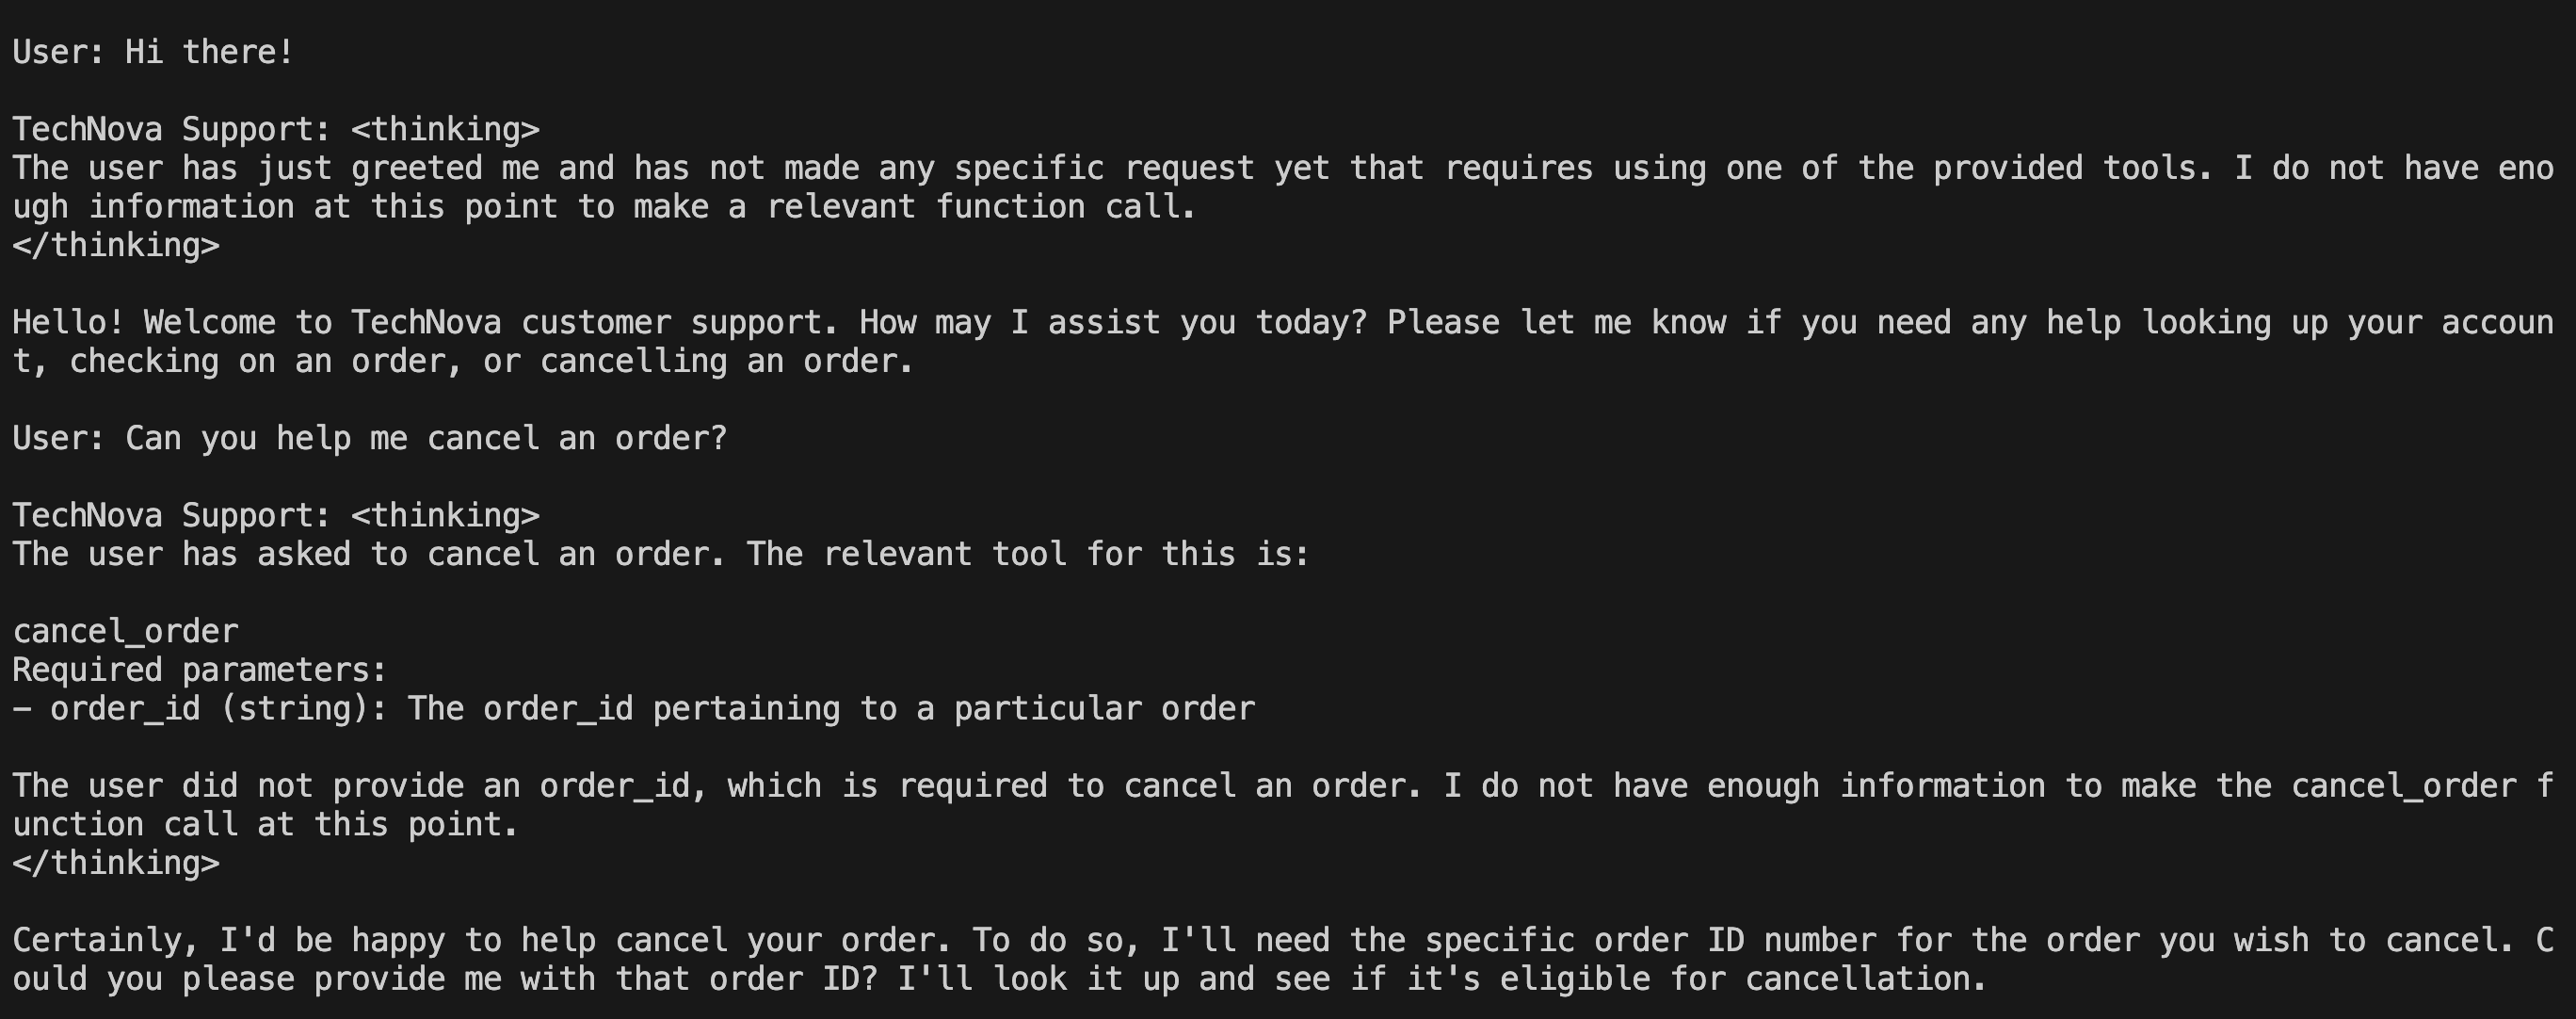

This thinking process tends to lead to better results, but it obviously makes for a terrible user experience. We don't want to expose that thinking logic to a user! The easiest fix here is to explicitly ask the model output its user-facing response in a particular set of XML tags. We start by updating the system prompt:

In [ ]:
system_prompt = """
You are a customer support chat bot for an online retailer called TechNova. 
Your job is to help users look up their account, orders, and cancel orders.
Be helpful and brief in your responses.
You have access to a set of tools, but only use them when needed.  
If you do not have enough information to use a tool correctly, ask a user follow up questions to get the required inputs.
Do not call any of the tools unless you have the required data from a user. 

In each conversational turn, you will begin by thinking about your response. 
Once you're done, you will write a user-facing response. 
It's important to place all user-facing conversational responses in <reply></reply> XML tags to make them easy to parse.
"""

Take a look at an example conversation output: 

![conversation8.png](./images/conversation8.png)


Claude is now responding with `<reply>` tags around the actual user-facing response.  All we need to do now is extract the content between those tags and make sure that's the only part of the response we actually print to the user.  Here's an updated `start_chat` function that does exactly that!

In [ ]:
import re

def extract_reply(text):
    pattern = r'<reply>(.*?)</reply>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return None    
    
def simple_chat():
    system_prompt = """
    You are a customer support chat bot for an online retailer called TechNova. 
    Your job is to help users look up their account, orders, and cancel orders.
    Be helpful and brief in your responses.
    You have access to a set of tools, but only use them when needed.  
    If you do not have enough information to use a tool correctly, ask a user follow up questions to get the required inputs.
    Do not call any of the tools unless you have the required data from a user. 

    In each conversational turn, you will begin by thinking about your response. 
    Once you're done, you will write a user-facing response. 
    It's important to place all user-facing conversational responses in <reply></reply> XML tags to make them easy to parse.
    """

    user_message = input("\nUser: ")
    messages = [{"role": "user", "content": [{"text": user_message}]}]

    while True:
        #If the last message is from the assistant, get another input from the user
        if messages[-1].get("role") == "assistant":
            user_message = input("\nUser: ")
            messages.append({"role": "user", "content": [{"text": user_message}]})

        converse_api_params = {
            "modelId": modelId,
            "system": [{"text": system_prompt}],
            "messages": messages,
            "inferenceConfig": {"maxTokens": 4096},
            "toolConfig":toolConfig,
        }

        response = bedrock_client.converse(**converse_api_params)

        messages.append({"role": "assistant", "content": response['output']['message']['content']})

        #If Claude stops because it wants to use a tool:
        if response['stopReason'] == "tool_use":
            tool_use = response['output']['message']['content'][-1] #Naive approach assumes only 1 tool is called at a time
            tool_id = tool_use['toolUse']['toolUseId']
            tool_name = tool_use['toolUse']['name']
            tool_input = tool_use['toolUse']['input']

            print(f"======Claude wants to use the {tool_name} tool======")

            #Actually run the underlying tool functionality on our db
            tool_result = process_tool_call(tool_name, tool_input)

            #Add our tool_result message:
            messages.append({
                "role": "user",
                "content": [
                    {
                        "toolResult": {
                            "toolUseId": tool_id,
                            "content": [
                                {"text": str(tool_result)}
                            ]
                        }
                    }
                ]
            })
        else: 
            #If Claude does NOT want to use a tool, just print out the text reponse
            model_reply = extract_reply({response['output']['message']['content'][0]['text']})
            print("\nTechNova Support: " + f"{model_reply}" )


# Start the chat!!
# simple_chat()

Here's a screenshot showing the impact of the above change: 

![conversation9.png](./images/conversation9.png)

***

## Final version

Here's a screenshot of a longer conversation with a version of this script that colorizes the output.

![conversation10.png](./images/conversation10.png)

***

## Closing notes

This is an educational demo made to illustrate the tool use workflow.  This script and prompt are NOT ready for production. The assistant responds with things like "You can find the order ID on the order confirmation email" without actually knowing if that's true. In the real world, we would need to provide Claude with lots of background knowledge about our particular company (at a bare minimum).  We also need to rigorously test the chatbot and make sure it behaves well in all situations.  Also, it's probably a bad idea to make it so easy for anyone to cancel an order! It would be pretty easy to cancel a lot of people's orders if you had access to their email, username, or phone number. In the real world, we would probably want some form of authentication.  Long story short: this is a demo and not a complete chatbot implementation!

***

## Exercise

* Add functionality to our assistant (and underlying `FakeDatabase` class) that allows a user to update their email and phone number.
* Define a new tool called `get_user_info` that combines the functionality of `get_user` and `get_customer_orders`. This tool should take a user's email, phone, or username as input and return the user's information along with their order history all in one go.
* Add error handling and input validation!


#### Bonus
* Update the chatbot to use an ACTUAL database instead of our `FakeDatabase` class.